Danyal Faheem
19I-2014 CS-F
Assignment 2

In [1]:
#Importing our required libraries here
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, LineString, Point
from random import randint
from copy import deepcopy
from math import degrees, atan, atan2, ceil, log
from itertools import repeat


Our drawing functions go here

In [2]:


# Function to draw a polygon in polygon shape
def drawPolygon(polygon):
    polygon1 = Polygon(polygon)
    x, y = polygon1.exterior.xy
    plt.plot(x, y)
    plt.show()

# Function to print a chromosome with spaces in between each point index
def printChromosome(chromosome):
    for i in range(len(chromosome)):
        if i % (len(bin(populationRange).replace("0b", ""))) == 0:
            print("", end=' ')
        print(chromosome[i], end='')
    print("")

# Function to display all the polygons in the population as well as their chromosomes
def printPopulation(population):
    for i in range(len(population)):
        print(population[i])
        printChromosome(makeChromosome(population[i]))
        drawPolygon(population[i])

Create Functions

In [3]:

# This functions creates an initial population with random polygon
def createPopulation(points, pop_size, pop_range):
    population = []
    # Run loop over predefined size
    for i in range(pop_size):
        temp1 = []
        for j in range(points):
            # Randomly create points in between range
            temp1.append([randint(0, pop_range), randint(0, pop_range)])
        if temp1 not in population:
            population.append(deepcopy(temp1))
    return population

# Function to convert a polygon into its chromosome counterpart
def makeChromosome(polygon):
    chromosome = ""
    for i in polygon:
        for j in i:
            # Convert decimal to binary
            b = bin(j).replace("0b", "")
            # Change bits to required number of bits
            b = ("0" * (len(bin(populationRange).replace("0b", "")) - len(b))) + b
            chromosome += b
    return chromosome

# Function to convert chromosome back to it's polygon counterpart
def makePolygon(chromosome):
    polygon = []
    j = 0
    while j < len(chromosome):
        temp = []
        # Get binary value of x of point
        i = chromosome[j:j+len(bin(populationRange).replace("0b", ""))]
        temp.append(int(i, 2))
        j += len(bin(populationRange).replace("0b", ""))
        # Get binary value of y of point
        i = chromosome[j:j+len(bin(populationRange).replace("0b", ""))]
        # add to temporary
        temp.append(int(i, 2))
        # Move iterator
        j += len(bin(populationRange).replace("0b", ""))
        # Add first point to polygon
        polygon.append(temp)
    return polygon

Fitness Functions

In [4]:
# Function to calculate angle between 3 points using simple inverse tan rule
def calculateAngle(point1, point2, point3):
    # Create two lines from the points
    line1 = [point1, point2]
    line2 = [point2, point3]
    # Check the gradient of line 1
    if (line1[1][0]-line1[0][0]) == 0:
        m2 = (line2[1][1]-line2[0][1])/(line2[1][0]-line2[0][0])
        return abs(float(90 - degrees(atan(m2))))
    # Check the gradient of line 2
    elif (line2[1][0]-line2[0][0]) == 0:
        m1 = (line1[1][1]-line1[0][1])/(line1[1][0]-line1[0][0])
        return abs(float(90 - degrees(atan(m1))))
    m1 = (line1[1][1]-line1[0][1])/(line1[1][0]-line1[0][0])
    m2 = (line2[1][1]-line2[0][1])/(line2[1][0]-line2[0][0])
    return abs(degrees(atan((m1-m2)/(1-(m1*m2)))))

# Our main fitness function which takes an entire population as input and returns fitness for the entire population, 0 is lowest and best
def fitnessFunction(population):
    # Our main lists to store data
    fitness = []
    angles = []
    for i in range(len(population)):
        j = 0
        # Make sure angles is empty
        angles.clear()
        # Count is our fitness value for each polygon, 0 at start
        count = 0
        while j < points:
                # Create line using two neighbouring points
                line1 = LineString([population[i][j], population[i][(j + 1) % points]])
                angles.append(calculateAngle(population[i][j], population[i][(j + 1) % points],population[i][(j + 2) % points]))
                # Add 1 to fitness value if angle greater than 180 found
                count += 1 if calculateAngle(population[i][j], population[i][(j + 1) % points],population[i][(j + 2) % points]) >= 180 else 0
                # To check intersection, we will check with 1 line ahead
                k = j + 2
                while k < points:
                    # Check if circle has been completed or not
                    if population[i][(k + 1) % points] != population[i][j]:
                        # Create line using two neighbouring points
                        line2 = LineString([population[i][k], population[i][(k + 1) % points]])
                        # Get points of intersection between the two lines
                        pt = line1.intersection(line2)
                        # If point of intersection exists, add points to fitness value
                        if pt.is_empty == False:
                            count += points
                    k += 1
                j += 1
        # Add value of count to fitness
        fitness.append(count)
    return fitness

Parent Selection

In [5]:
# Function to sort the population using fitness values
# Algorithm applied is simple bubble sort
def sortPopulation(fringe1, population1):
    population = deepcopy(population1)
    fringe = deepcopy(fringe1)
    for i in range(len(fringe)):
        for j in range(len(fringe) - 1):
            if fringe[j] > fringe[j + 1]:
                fringe[j], fringe[j + 1] = fringe[j + 1], fringe[j]
                population[j], population[j + 1] = population[j + 1], population[j]
    return fringe, population

# Roulette wheel function to select parents for genetic operations
def rouletteWheel(population, fitness):
    # First sort the population according to it's fitness values
    fitness, population = sortPopulation(fitness, population)
    # List of wheel and parents
    wheel = []
    parents = []
    for i in range(len(fitness)):
        # If fitness value 0 achieved, return here as goal found
        if fitness[i] == 0:
            print(population[i])
            printChromosome(makeChromosome(population[i]))
            drawPolygon(population[i])
            return parents, 1
        # Using 1/log method, creating entries in wheel, the less the fitness value, the more entries and hence more probability
        j = ceil(10 * (1 / log(fitness[i] + 2)))
        wheel.extend(repeat(i, j))
    i = 0
    while i < ceil(len(population) * 0.2):
        # Get a random index in wheel and return its value which would be index in population
        if population[wheel[randint(0, len(wheel) - 1)]] not in parents:
            # Add that to parents
            parents.append(population[wheel[randint(0, len(wheel) - 1)]])
            i += 1

    return parents, 0

Genetic Operations

In [6]:
# Function to perform crossover on parents and create a new generation
def crossover(parents):
    generation = []
    i = 0
    while i < len(parents) - 1:
        # Get chromosomes of first two parents
        chromosome1 = makeChromosome(parents[i])
        chromosome2 = makeChromosome(parents[i + 1])
        i1v = []
        i2v = []
        # Run loop for as many points
        for a in range(ceil(points)):
            # Generate random indexes which correspond to points to in the chromosomes
            j = len(bin(populationRange).replace("0b", "")) * randint(0, points - 1) * 2
            k = len(bin(populationRange).replace("0b", "")) * randint(0, points - 1) * 2
            # Splice the chromosomes respectively
            i1 = chromosome1[j:j+(len(bin(populationRange).replace("0b", "")) * 2)]
            i2 = chromosome2[k:k+(len(bin(populationRange).replace("0b", "")) * 2)]
            if i1 not in i1v and i2 not in i2v:
                # Swap out each chromosomes
                chromosome1 = chromosome1[0:k] + i2 + chromosome1[k+(len(bin(populationRange).replace("0b", "")) * 2):]
                chromosome2 = chromosome2[0:j] + i1 + chromosome2[j+(len(bin(populationRange).replace("0b", "")) * 2):]
                i1v.append(i1)
                i2v.append(i2)
            # Loop runs till number of points, meaning that crossover is basically random points 
            # taken from each chromosome and added to other
        # Convert to polygon and add back
        if makePolygon(chromosome1) not in generation:
            generation.append(makePolygon(chromosome1))
        if makePolygon(chromosome2) not in generation:
            generation.append(makePolygon(chromosome2))
        i += 2
    return generation


# Function to perform mutataion on generation and return mutated generation
def mutation(generation):
    size = ceil(len(generation))
    change = set()
    for i in range(size):
        change.add(randint(0, len(generation) - 1))
    for c in change:
        # Get chromosome of current index
        chromosome = makeChromosome(generation[c])
        # Mutate for number of points
        for j in range(points):
            # Get random index to mutate
            index = randint(0, len(chromosome) - 1)
            # Change bits
            if chromosome[index] == "0":
                chromosome = chromosome[:index] + "1" + chromosome[index + 1:]
            elif chromosome[index] == "1":
                chromosome = chromosome[:index] + "0" + chromosome[index + 1:]
        generation[c] = deepcopy(makePolygon(chromosome))
    return generation


Genetic Algorithm

[[149, 123], [78, 123], [177, 27], [229, 191], [159, 59], [184, 188], [173, 237]]
 10010101 01111011 01001110 01111011 10110001 00011011 11100101 10111111 10011111 00111011 10111000 10111100 10101101 11101101


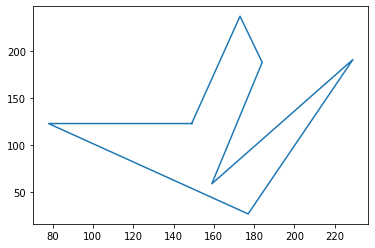

Solution Found at generation 0


In [7]:
# Our main genetic algorithm function which takes number of generations and population size as input
def geneticAlgorithm(generations, populationSize):
    # Create the population depending on size, number of points per polygon and range
    population = createPopulation(points, populationSize, populationRange)
    # Run for generations times
    for i in range(generations):
        # Get fitness values of the population
        fitness = fitnessFunction(population)
        # Sort popoulation based on the fitness values
        fitness, population = sortPopulation(fitness, population)
        # Apply roulette wheel selection to get parents for genetic operations
        parents, flag = rouletteWheel(population, fitness)
        # If fitness value found, exit function
        if flag:
            print("Solution Found at generation", i)
            return
        # Print the best solution at each generation
        print("Best solution at generation", i)
        print(population[0])
        printChromosome(makeChromosome(population[0]))
        drawPolygon(population[0])
        # Get new generation after applying crossover on parents
        generation = crossover(parents)
        # Get mutated generation after applying mutation on new generation
        mutatedGeneration = mutation(generation)
        # Remove the worst polygons from populations
        for j in range(len(mutatedGeneration)):
            population.pop()
        # Add mutated generation to population
        population.extend(mutatedGeneration)



# Our main functino
def main():
    global points
    global populationSize
    global populationRange
    # Points for each polygon
    points = 7
    populationSize = 50
    populationRange = (2**8) - 1
    geneticAlgorithm(10, populationSize)
main()


In [8]:

# def onSegment(point1, point3, p):
#     return min(point1[0], point3[0]) <= p[0] <= max(point1[0], point3[0]) and min(point1[1], point3[1]) <= p[1] <= max(point1[1], point3[1])


# def orientation(p, q, r):
#     val = ((q[1] - p[1]) * (r[0] - q[0])) - ((q[0] - p[0]) * (r[1] - q[1]))
#     if val == 0:
#         return 0
#     elif val > 0:
#         return 1
#     else:
#         return -1


# def ifIntersect(point1, point2, point3, point4):
#     pass

#     o1 = orientation(point1, point2, point3)
#     o2 = orientation(point1, point2, point4)
#     o3 = orientation(point3, point4, point1)
#     o4 = orientation(point3, point4, point2)

#     if o1 != o2 and o3 != o4:
#         return True

#     if (o2 == 0 and onSegment(point1, point2, point4)) or (o3 == 0 and onSegment(point3, point4, point1)) or (o4 == 0 and onSegment(point3, point4, point2) ):
#         return True

#     return False


#     # for i in range(len(population)):
#     #     j = 0
#     #     check = True
#     #     while j < points:
#     #         check = ifIntersect(population[i][j], population[i][(j + 1) % points], population[(j + 1) % points][0], population[(j + 2) % points][1])
#     #         if check == True:
#     #             print(population[i][j], population[i][(j + 1) % points], population[(j + 1) % points][0], population[(j + 2) % points][1])
#     #             drawPolygon(population[i])
#     #             # break
#     #         j += 1
#     #     if check == True:
#     #         print(check)
#     #         print(population[i])
#     #         drawPolygon(population[i])